<a href="https://colab.research.google.com/github/JoseEliasDuranRoa/Prediction-Models-for-Housing-Prices-in-Chennai/blob/main/ProblemSet1_Dur%C3%A1nRoa_Jos%C3%A9El%C3%ADas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Please make a copy of this notebook and replace "LastName" and "FirstName" in the title with your own names. Also, write your name in the following text block.

* Then, fill in the file with your code and comments on the results.

* Finally, share your completed work with me by sending the link via email as your final submission, no later than **January 6th, 2025**.

* You can contact me if you have any questions. If necessary, we can meet either face-to-face or via online video calls to resolve them.

---

**Last Name:** Durán Roa


**First Name:** José Elías



---

# Problem 1: Prediction




In the shared subfolder "Problem1" you will find .zip files with datasets (and information about them). You must fill the "Choose_Dataset" file with your choice. You *cannot* choose an option previouly selected by somebody else. But note that in some cases you can choose among different subsamples of the same dataset.

## a) Data Cleaning

* Read the data; pay attention to use the right data type for each variable.

In [21]:
#Import modules
import zipfile, os
import pandas as pd
import numpy as np
pd.__version__

#from google.colab import drive

# Import the data
zip_file_path = '/content/drive/My Drive/chennai.zip'
housing = pd.read_csv(zipfile.ZipFile(zip_file_path).extract('Chennai_housing_sale_2.csv'), index_col = 0)

#Correct data type
housing['DATE_SALE'] = pd.to_datetime(housing['DATE_SALE'], dayfirst=True)
housing['DATE_BUILD'] = pd.to_datetime(housing['DATE_BUILD'], dayfirst=True)
housing['N_BEDROOM'] = housing['N_BEDROOM'].astype('Int64')
housing['N_BATHROOM'] = housing['N_BATHROOM'].astype('Int64')

At this point, we have successfully loaded data related to housing in Chennai, a major city in India, into memory. This data is organized in a DataFrame with 21 distinct variables, which include information about property characteristics, sale prices, construction dates, and various amenities associated with the houses.

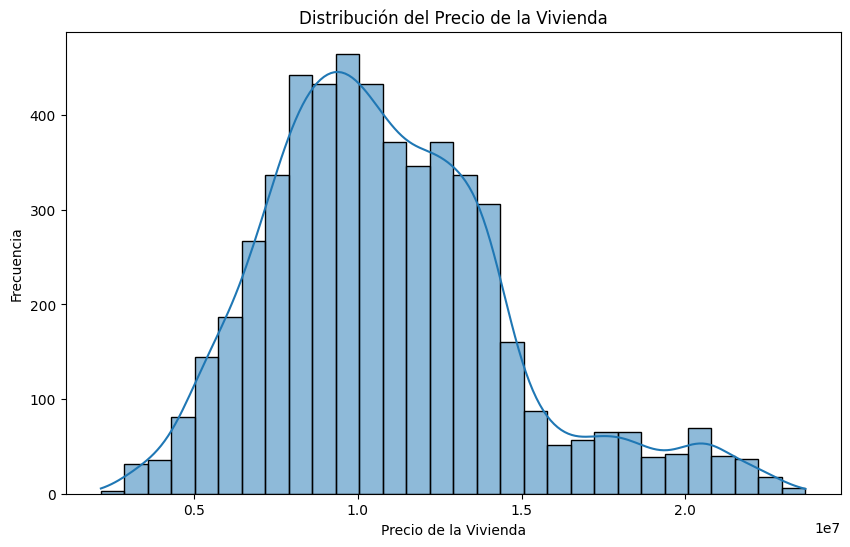

In [25]:
# House prices distribution
plt.figure(figsize=(10, 6))
sns.histplot(housing['SALES_PRICE'], bins=30, kde=True)
plt.title('Distribución del Precio de la Vivienda')
plt.xlabel('Precio de la Vivienda')
plt.ylabel('Frecuencia')
plt.show()

El principal propósito del trabajo será predecir el precio de la vivienda. En el gráfico 1 observamos que...  

In [29]:
# Stastical Description of Data
housing.describe()

,INT_SQFT,DATE_SALE,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,DATE_BUILD,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,REG_FEE,COMMIS,SALES_PRICE
count,5331.000000,5331,5323.000000,5319.0,5330.0,5331.000000,5331,5331.000000,5331.000000,5331.000000,5285.000000,5331.000000,5331.000000,5.331000e+03
mean,1384.132433,2010-03-30 04:47:08.137309952,99.276724,1.634894,1.21257,3.692178,1985-12-12 21:15:29.881823296,3.504971,3.514988,3.471300,3.494244,376469.471019,140087.972050,1.090387e+07
min,500.000000,2004-01-16 00:00:00,0.000000,1.0,1.0,2.000000,1949-10-28 00:00:00,2.000000,2.000000,2.000000,2.000000,71177.000000,5378.000000,2.156875e+06
25%,990.000000,2008-10-31 00:00:00,48.500000,1.0,1.0,3.000000,1976-10-10 00:00:00,2.700000,2.700000,2.700000,3.110000,272191.000000,82771.500000,8.309780e+06
50%,1363.000000,2010-04-14 00:00:00,98.000000,1.0,1.0,4.000000,1986-07-04 00:00:00,3.500000,3.500000,3.400000,3.500000,353577.000000,128213.000000,1.044440e+07
75%,1749.000000,2011-09-03 00:00:00,149.000000,2.0,1.0,4.000000,1996-07-12 12:00:00,4.300000,4.300000,4.200000,3.870000,451230.000000,185065.000000,1.303956e+07
max,2496.000000,2015-02-17 00:00:00,200.000000,4.0,2.0,6.000000,2010-07-14 00:00:00,5.000000,5.000000,5.000000,4.950000,983922.000000,495405.000000,2.366734e+07
std,459.970950,NaN,58.162912,0.813223,0.409165,1.027380,NaN,0.899030,0.903528,0.881812,0.528255,140722.218102,78873.426851,3.720762e+06


Aquí pongo una interpretación de los resultados, more less.

In [32]:
# Identyfing AREA typos
housing.AREA.value_counts()

# Fixing AREA typos
housing.AREA.replace(['Ana Nagar','Ann Nagar'],'Anna Nagar',inplace=True)
housing.AREA.replace('Karapakkam','Karapakam',inplace=True)
housing.AREA.replace(['Chrompt','Chrmpet','Chormpet'],'Chrompet',inplace=True)
housing.AREA.replace('KKNagar','KK Nagar',inplace=True)
housing.AREA.replace('TNagar','T Nagar',inplace=True)
housing.AREA.replace('Adyr','Adyar',inplace=True)
housing.AREA.replace('Velchery','Velachery',inplace=True)
housing.BUILDTYPE.replace('Comercial','Commercial',inplace=True)
housing.BUILDTYPE.replace('Other','Others',inplace=True)
housing.UTILITY_AVAIL.replace('AllPub','All Pub',inplace=True)
housing.UTILITY_AVAIL.replace('NoSewr','NoSeWa',inplace=True)
housing.UTILITY_AVAIL.replace('NoSewr ','NoSeWa',inplace=True)
housing.SALE_COND.replace('Ab Normal','AbNormal',inplace=True)
housing.SALE_COND.replace(['PartiaLl','Partiall'],'Partial',inplace=True)
housing.SALE_COND.replace('Adj Land','AdjLand',inplace=True)
housing.PARK_FACIL.replace('Noo','No',inplace=True)
housing.STREET.replace('Pavd','Paved',inplace=True)
housing.STREET.replace('NoAccess','No Access',inplace=True)

#Checking missing values
# Valores faltantes
missing_values = housing.isnull().sum()
print(missing_values[missing_values > 0]);

DIST_MAINROAD     8
N_BEDROOM        12
N_BATHROOM        1
QS_OVERALL       46
dtype: int64


<ipython-input-32-ae85d30d8a20>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing.BUILDTYPE.replace('Comercial','Commercial',inplace=True)
<ipython-input-32-ae85d30d8a20>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

Adicionalmente podemos observar que existen errores de digitación en el Área en las que se localiza el hogar, estos errores de digitación suelen comunes... procedemos a corregirlos:

## b)

* Create a Pandas series your the outcome variable and a Pandas data frame with those variables that you consider as relevant predictors (probably, most of them). Additionally, you can think about transforming some of them (eg., join categories with few observations, generating dummies, etc.).

* Split your sample into a training set and a testing set.


In [ ]:
# Your code here

## c)

* Estimate a linear regression model by OLS using your preferred specification or specifications for prediction. You can use pre-processing steps if necessary (for polynomials, interactions, dealing with NAs, etc.). Comment on the results.

* Obtain the RMSE and the MAE as metrics of predictive performance of the model(s).



In [ ]:
# Your code here


> Your comments here


## d)

* Estimate a LASSO model using the pre-processing steps that you consider necessary. Note that you must choose the optimal value of the penalization hyperparameter by cross-validation before estimating the best LASSO model (which use that value)

* Comment on the results.

* Obtain the RMSE and the MAE as metrics of predictive performance of the model.

In [ ]:
# Your code here


> Your comments here


## e)

* Estimate a regression tree model using the pre-processing steps that you consider necessary. Note that you must choose the optimal value of the hyperparameters by cross-validation before estimating the best tree model. You can focus on tuning the cost-complexity parameter; you can fix the `min_samples_leaf` to a value of your choice (you can try a few of them before choosing one).

* Show a figure with the resulting tree. Comment on the results.

* Show in a table the variable importance according to this model (you can also provide a figure if you want). Comment on the results.

* Obtain the RMSE and the MAE as metrics of predictive performance of the model.

In [ ]:
# Your code here


> Your comments here


## f)

* Estimate a random forest model using the pre-processing steps that you consider necessary. Note that you must choose the optimal value of the hyperparameters by cross-validation before estimating the best model. You can focus on tuning either `min_samples_leaf` or `max_features`, but you should try a few of the other one.

* Show in a table the variable importance according to this model (you can also provide a figure if you want). Comment on the results.

* Obtain the RMSE and the MAE as metrics of predictive performance of the model.

In [ ]:
# Your code here


> Your comments here


## g)

Finally, discuss which prediction model is the best one. Also, briefly comment on any other key insights you can learn from one or more of these models.



> Your comments here


---

# Problem 2: Financial Investment

* This problem is **optional**. Completing it will give you 1 extra point.

* We are interested in estimating the effect of participation in 401(k) pension plans on employees’ net financial assets. The dataset [pension.csv](https://raw.githubusercontent.com/albarran/00datos/refs/heads/main/pension.csv) contains information about net financial assets (*net_tfa*) and participation in a 401(k) plan (*p401*), along with several additional individual characteristics: age, income, education, family size, marital status, having two earners in the household, having a defined benefit (DB) pension (a type of retirement plan where an employer guarantees a specified retirement amount), participation in an IRA (Individual Retirement Account, a type of retirement savings account with tax advantages), and homeownership. You can find more information about the variables [here](https://search.r-project.org/CRAN/refmans/hdm/html/pension.html).

* Since saving preferences (which are unobservable) can directly affect net asset holdings and the decision to participate, and may also be correlated with observable characteristics (e.g., income), participation in 401(k) plans can be endogenous. However, it is possible to exploit randomness (conditional on confounding variables) in eligibility for 401(k) plans (*e401*). An instrumental variable (IV) approach could be used to estimate the causal effect, but in this case, we will focus on estimating the intention-to-treat effect.


* Load the data and check the variables types.

In [ ]:
# Your code here

## a)

* Estimate using OLS a model to examine the effect of 401(k) eligibility on asset holdings, controlling for relevant confounding factors.

* Carefully consider how each variable should enter the model (e.g., whether education should be treated as a continuous or categorical variable). Additionally, consider whether polynomial terms or interaction effects might be useful. There is no universally correct choice, but your decisions should be justified and applied consistently throughout the analysis.

* Show the estimated intention-to-treat effect and its standard error and other relevant information to comment on the evidence on the results.

In [ ]:
# Your code here


> Your comments here


## b)

* Repeat the part a) but estimating now the model using LASSO.

In [ ]:
# Your code here


> Your comments here


## c)

* Repeat the part a) again but using Double-selection LASSO.

* Comment on the differences with the previous results and discuss your overall conclusion about the evidence.

In [ ]:
# Your code here


> Your comments here


## d)

* Finally repeat the estimation of the ITT using Double ML with Random Forest.

* Show the results and discuss

In [ ]:
# Your code here


> Your comments here